In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#### TODO install geopandas
#import geopandas as gp
from sklearn.preprocessing import normalize
from scipy.sparse import coo_matrix, csr_matrix

Read in standardized csv files and merge them into one Dataframe

In [2]:
df_form = pd.read_csv("formationout.csv")
df_well = pd.read_csv("out.csv")
#Merge the 2 CSVs by API number
df_merged = df_well.merge(df_form, how = "left", on = "API Number")
print(df_merged.head())



     API Number  Northing   Easting  True Vertical Depth  Normalized TVD  \
0  490251039700  974652.3  794810.9              -2007.0        0.451998   
1  490251039700  974652.3  794810.9              -2007.0        0.451998   
2  490251039700  974652.3  794810.9              -2007.0        0.451998   
3  490251039700  974652.3  794810.9              -2007.0        0.451998   
4  490251039700  974652.3  794810.9              -2007.0        0.451998   

  Well Number  Form Alias   Top MD  
0     34-A-21        22.0  1564.04  
1     34-A-21        19.0   910.29  
2     34-A-21        10.0  2785.42  
3     34-A-21        20.0  1461.42  
4     34-A-21        23.0   527.25  


Make a sparse matrix from the Dataframe

In [3]:
D_df = df_merged.pivot_table("Top MD","Form Alias","API Number").fillna(0)
df_merged[["Top MD", "Form Alias", "API Number"]]

,Top MD,Form Alias,API Number
0,1564.04,22.0,490251039700
1,910.29,19.0,490251039700
2,2785.42,10.0,490251039700
3,1461.42,20.0,490251039700
4,527.25,23.0,490251039700
5,126.50,0.0,490251039700
6,211.43,3.0,490251039700
7,1697.53,5.0,490251039700
8,1908.68,6.0,490251039700
9,284.32,4.0,490251039700


Trying different ways of normalizing R, demeaning and normalizing with SKLearn

In [4]:
R = D_df.values
well_depth_mean = np.mean(R, axis = 1)
R_normalize = normalize(R, norm = "l2")
R_demeaned = R - well_depth_mean.reshape(-1, 1)

Create binarized matrix with values of 1 where there are depth values in the sparse matrix R and values of 0 where there are not depth values in the sparse matrix R.

In [5]:
from sklearn.preprocessing import binarize
A = binarize(R)

This is the code that runs Alternating Least Squares factorization

In [6]:
#ALS factorization from 
# https://github.com/mickeykedia/Matrix-Factorization-ALS/blob/master/ALS%20Python%20Implementation.py
# here items are the formation and users are the well
def runALS(A, R, n_factors, n_iterations, lambda_):
    """
    Runs Alternating Least Squares algorithm in order to calculate matrix.
    :param A: User-Item Matrix with ratings
    :param R: User-Item Matrix with 1 if there is a rating or 0 if not
    :param n_factors: How many factors each of user and item matrix will consider
    :param n_iterations: How many times to run algorithm
    :param lambda_: Regularization parameter
    :return:
    """
    print("Initiating ")
    MAE = []
    for i in range(1, n_factors):
        lambda_ = lambda_
        n_factors = i
        n, m = A.shape
        n_iterations = n_iterations
        Users = 5 * np.random.rand(n, n_factors)
        Items = 5 * np.random.rand(n_factors, m)

        def get_error(A, Users, Items, R):
            # This calculates the MSE of nonzero elements
            return np.sum((R * (A - np.dot(Users, Items))) ** 2) / np.sum(R)

        MSE_List = []

        print("Starting Iterations")
        for iter in range(n_iterations):
            for i, Ri in enumerate(R):
                Users[i] = np.linalg.solve(
                    np.dot(Items, np.dot(np.diag(Ri), Items.T))
                    + lambda_ * np.eye(n_factors),
                    np.dot(Items, np.dot(np.diag(Ri), A[i].T)),
                    ).T
            print(
                "Error after solving for User Matrix:",
                get_error(A, Users, Items, R),
                )

            for j, Rj in enumerate(R.T):
                Items[:, j] = np.linalg.solve(
                    np.dot(Users.T, np.dot(np.diag(Rj), Users))
                    + lambda_ * np.eye(n_factors),
                    np.dot(Users.T, np.dot(np.diag(Rj), A[:, j])),
                    )
            print(
                "Error after solving for Item Matrix:",
                 get_error(A, Users, Items, R),
                )

            MSE_List.append(get_error(A, Users, Items, R))
            print("%sth iteration is complete..." % iter)
        MAE.append(MSE_List)
    return Users, Items, MAE
    
    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # plt.plot(range(1, len(MSE_List) + 1), MSE_List); plt.ylabel('Error'); plt.xlabel('Iteration')
    # plt.title('Python Implementation MSE by Iteration \n with %d formations and %d wells' % A.shape);
    # plt.savefig('Python MSE Graph.pdf', format='pdf')
    # plt.show()

In [7]:
U, Vt, MAE_list = runALS(R_normalize, A, 20, 20, 0.1)

Initiating 
Starting Iterations
Error after solving for User Matrix: 0.0022450399410865957
Error after solving for Item Matrix: 0.004568420598544556
0th iteration is complete...
Error after solving for User Matrix: 0.0029929689651173536
Error after solving for Item Matrix: 0.0019374914870447387
1th iteration is complete...
Error after solving for User Matrix: 0.0013892415144855846
Error after solving for Item Matrix: 0.0013191028073591825
2th iteration is complete...
Error after solving for User Matrix: 0.0010429523524587462
Error after solving for Item Matrix: 0.0010507006735590101
3th iteration is complete...
Error after solving for User Matrix: 0.0008751766878825786
Error after solving for Item Matrix: 0.0008957641973281577
4th iteration is complete...
Error after solving for User Matrix: 0.0007705756735641456
Error after solving for Item Matrix: 0.0007943169851666652
5th iteration is complete...
Error after solving for User Matrix: 0.0007005521187164948
Error after solving for Item

Error after solving for User Matrix: 0.0001090409865089128
Error after solving for Item Matrix: 0.00011306170016084419
15th iteration is complete...
Error after solving for User Matrix: 0.00010782996111039304
Error after solving for Item Matrix: 0.00011129729304440104
16th iteration is complete...
Error after solving for User Matrix: 0.00010716388805516049
Error after solving for Item Matrix: 0.0001100652745508976
17th iteration is complete...
Error after solving for User Matrix: 0.00010677318223850328
Error after solving for Item Matrix: 0.00010916779873867974
18th iteration is complete...
Error after solving for User Matrix: 0.00010653675854095447
Error after solving for Item Matrix: 0.0001084990025529644
19th iteration is complete...
Starting Iterations
Error after solving for User Matrix: 0.0006321009777628824
Error after solving for Item Matrix: 0.005688612973085282
0th iteration is complete...
Error after solving for User Matrix: 0.0029323429031831998
Error after solving for Item

Error after solving for User Matrix: 4.357613513728e-05
Error after solving for Item Matrix: 4.6145063021113216e-05
10th iteration is complete...
Error after solving for User Matrix: 4.331287834257502e-05
Error after solving for Item Matrix: 4.539097250381005e-05
11th iteration is complete...
Error after solving for User Matrix: 4.3136924710606754e-05
Error after solving for Item Matrix: 4.481218832212265e-05
12th iteration is complete...
Error after solving for User Matrix: 4.300459833888337e-05
Error after solving for Item Matrix: 4.435016206287122e-05
13th iteration is complete...
Error after solving for User Matrix: 4.289316261846082e-05
Error after solving for Item Matrix: 4.396931573265415e-05
14th iteration is complete...
Error after solving for User Matrix: 4.279091253122343e-05
Error after solving for Item Matrix: 4.364767573327524e-05
15th iteration is complete...
Error after solving for User Matrix: 4.269240490306846e-05
Error after solving for Item Matrix: 4.337137291034334

Error after solving for User Matrix: 3.5181646023060914e-05
Error after solving for Item Matrix: 3.8251697942182445e-05
6th iteration is complete...
Error after solving for User Matrix: 3.444797869323719e-05
Error after solving for Item Matrix: 3.6830089348960486e-05
7th iteration is complete...
Error after solving for User Matrix: 3.411670423991232e-05
Error after solving for Item Matrix: 3.5996341801794224e-05
8th iteration is complete...
Error after solving for User Matrix: 3.398362982497739e-05
Error after solving for Item Matrix: 3.5490808312053624e-05
9th iteration is complete...
Error after solving for User Matrix: 3.395385880079123e-05
Error after solving for Item Matrix: 3.517835506122009e-05
10th iteration is complete...
Error after solving for User Matrix: 3.397918761655232e-05
Error after solving for Item Matrix: 3.498393752826188e-05
11th iteration is complete...
Error after solving for User Matrix: 3.40331552484966e-05
Error after solving for Item Matrix: 3.48636699642389

Error after solving for User Matrix: 9.237891640255981e-05
Error after solving for Item Matrix: 7.216395013279456e-05
2th iteration is complete...
Error after solving for User Matrix: 5.93130614574011e-05
Error after solving for Item Matrix: 5.127761564111167e-05
3th iteration is complete...
Error after solving for User Matrix: 4.754616780955836e-05
Error after solving for Item Matrix: 4.299118676664283e-05
4th iteration is complete...
Error after solving for User Matrix: 4.171112501898286e-05
Error after solving for Item Matrix: 3.879150667410732e-05
5th iteration is complete...
Error after solving for User Matrix: 3.845002250118368e-05
Error after solving for Item Matrix: 3.6473245452278675e-05
6th iteration is complete...
Error after solving for User Matrix: 3.655026548563515e-05
Error after solving for Item Matrix: 3.516864683252749e-05
7th iteration is complete...
Error after solving for User Matrix: 3.5434844793086485e-05
Error after solving for Item Matrix: 3.444749605842521e-05

Error after solving for User Matrix: 3.398126695006363e-05
Error after solving for Item Matrix: 3.392108840240094e-05
18th iteration is complete...
Error after solving for User Matrix: 3.4003831719284515e-05
Error after solving for Item Matrix: 3.396901235414994e-05
19th iteration is complete...
Starting Iterations
Error after solving for User Matrix: 0.000293271009898798
Error after solving for Item Matrix: 0.007101731125473729
0th iteration is complete...
Error after solving for User Matrix: 0.001611424421643948
Error after solving for Item Matrix: 0.00016425938262374005
1th iteration is complete...
Error after solving for User Matrix: 9.391415533490968e-05
Error after solving for Item Matrix: 6.843750474583943e-05
2th iteration is complete...
Error after solving for User Matrix: 5.653135266792985e-05
Error after solving for Item Matrix: 4.910509813516885e-05
3th iteration is complete...
Error after solving for User Matrix: 4.547201008977377e-05
Error after solving for Item Matrix: 4

Error after solving for User Matrix: 3.415326347734614e-05
Error after solving for Item Matrix: 3.3521860045404814e-05
13th iteration is complete...
Error after solving for User Matrix: 3.409118422536097e-05
Error after solving for Item Matrix: 3.3601229351182014e-05
14th iteration is complete...
Error after solving for User Matrix: 3.405893461318218e-05
Error after solving for Item Matrix: 3.368078407293568e-05
15th iteration is complete...
Error after solving for User Matrix: 3.404683524316918e-05
Error after solving for Item Matrix: 3.375696291611771e-05
16th iteration is complete...
Error after solving for User Matrix: 3.404824057384353e-05
Error after solving for Item Matrix: 3.382792372091157e-05
17th iteration is complete...
Error after solving for User Matrix: 3.405854524388127e-05
Error after solving for Item Matrix: 3.389286936220588e-05
18th iteration is complete...
Error after solving for User Matrix: 3.40745399289709e-05
Error after solving for Item Matrix: 3.3951627416923

Below finds the index of the minimum of the maximum error after each set of iterations. This is the optimal value for the parameter n_factors.

In [16]:
MAE_max = []
#get a list of the max errors from each value of n_factor
for i in MAE_list:
    MAE_max.append(max(i))
#The index of the minimum max error is the optimal n_factor value
print(MAE_max.index(min(MAE_max)))

0


In [17]:
recommendations = np.dot(U, Vt)
recsys_df = pd.DataFrame(data = recommendations[0:, 0:], index = D_df.index,
                        columns = D_df.columns)
recsys_df.head()

API Number,490250632500,490250632700,490250632800,490250632900,490250633200,490250633400,490250633800,490250633900,490250634000,490250634100,...,490252284701,490252303100,490252304000,490252304700,490252304800,490252305400,490252305500,490252319500,490252345102,490252347904
Form Alias,,,,,,,,,,,,,,,,,,,,,
0.0,0.044483,0.061559,0.053778,0.072642,0.084088,0.062812,0.076593,0.072158,0.050284,0.061397,...,0.028860,0.025026,0.019918,0.041003,0.025549,0.024647,0.078469,0.016901,0.017233,0.023570
1.0,0.051017,0.087104,0.069957,0.109986,0.135598,0.089274,0.098134,0.110486,0.062227,0.084762,...,0.039133,-0.018158,-0.021838,0.036158,0.009640,0.006989,0.115555,0.007191,0.016744,0.018981
2.0,0.050844,0.089763,0.071202,0.114388,0.142148,0.092057,0.098530,0.115076,0.062831,0.087042,...,0.038709,-0.026310,-0.029623,0.032435,0.005460,0.002490,0.119740,0.002551,0.016638,0.017921
3.0,0.043347,0.058225,0.051537,0.067948,0.077766,0.059380,0.080220,0.067365,0.048515,0.058311,...,0.029013,0.027479,0.022303,0.042165,0.028001,0.027090,0.073742,0.018908,0.018712,0.024983
4.0,0.048960,0.064738,0.057713,0.075096,0.085404,0.066010,0.092957,0.074374,0.054513,0.064983,...,0.034972,0.034400,0.028403,0.053002,0.034947,0.033789,0.081706,0.025507,0.023910,0.030858


Plot the recommended depths for all formations for the first 5 wells vs the actual depths

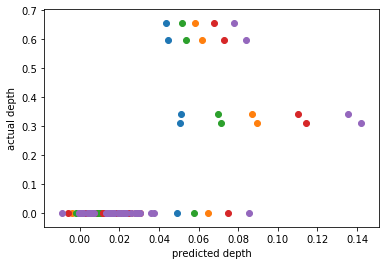

In [36]:
#TODO Ask if this normalization is correct or not
D_df_normalized = normalize((D_df.iloc[0:, 1].values).reshape(1, -1), norm='l2')
for i in range(5):
    plt.scatter(recsys_df.iloc[0:, i].values, D_df_normalized) #plot predicted vs actual
    plt.xlabel('predicted depth')
    plt.ylabel('actual depth')
    plt.plot(np.arange(0,recsys_df.iloc[0:,i].max()))

Predicted depths

In [37]:
recsys_df.iloc[0:, 1]

Form Alias
0.0     0.061559
1.0     0.087104
2.0     0.089763
3.0     0.058225
4.0     0.064738
5.0     0.015443
6.0     0.014228
7.0     0.014913
8.0     0.011674
9.0     0.012587
10.0    0.010838
11.0    0.011296
12.0    0.017413
13.0    0.006252
14.0    0.006769
15.0    0.018947
16.0    0.015238
17.0    0.015216
18.0    0.011403
19.0    0.015722
20.0    0.012406
21.0    0.022830
22.0    0.014002
23.0    0.019819
24.0    0.019832
25.0    0.019839
26.0    0.021075
27.0    0.021298
28.0    0.011026
29.0    0.011097
30.0    0.011068
31.0    0.010203
32.0    0.011006
33.0    0.011244
34.0    0.023870
35.0    0.000757
36.0    0.002221
37.0    0.002620
38.0    0.005107
39.0    0.002620
40.0   -0.003623
41.0    0.003904
42.0    0.002620
43.0    0.002363
44.0    0.002214
45.0    0.004733
46.0    0.001499
47.0    0.001683
48.0    0.001505
49.0    0.001506
50.0    0.001500
51.0    0.001710
52.0    0.001053
53.0    0.001053
54.0    0.000795
55.0    0.000795
56.0    0.000795
57.0    0.009304
58.

Actual depths

In [38]:
D_df.iloc[0:, 1]

Form Alias
0.0     877.38
1.0     503.67
2.0     455.35
3.0     963.16
4.0       0.00
5.0       0.00
6.0       0.00
7.0       0.00
8.0       0.00
9.0       0.00
10.0      0.00
11.0      0.00
12.0      0.00
13.0      0.00
14.0      0.00
15.0      0.00
16.0      0.00
17.0      0.00
18.0      0.00
19.0      0.00
20.0      0.00
21.0      0.00
22.0      0.00
23.0      0.00
24.0      0.00
25.0      0.00
26.0      0.00
27.0      0.00
28.0      0.00
29.0      0.00
30.0      0.00
31.0      0.00
32.0      0.00
33.0      0.00
34.0      0.00
35.0      0.00
36.0      0.00
37.0      0.00
38.0      0.00
39.0      0.00
40.0      0.00
41.0      0.00
42.0      0.00
43.0      0.00
44.0      0.00
45.0      0.00
46.0      0.00
47.0      0.00
48.0      0.00
49.0      0.00
50.0      0.00
51.0      0.00
52.0      0.00
53.0      0.00
54.0      0.00
55.0      0.00
56.0      0.00
57.0      0.00
58.0      0.00
59.0      0.00
Name: 490250632700, dtype: float64

Text(0, 0.5, 'Easting')

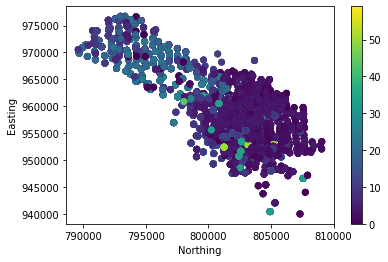

In [21]:
plt.scatter(df_merged.Easting, df_merged.Northing, c = df_merged.iloc[0:, 6])
plt.colorbar()
plt.xlabel("Northing")
plt.ylabel("Easting")

